## Questions to ask the data:
1. What features need immediate attention for transformation? (e.g. dates, categorical, etc.)
1. Look at higher correlation feature distributions
1. Are there any features that won't be of much value predicting the target? e.g.
    - high cardinality
    - high % data missing
    - high zero count
1. Are there anomalies in some of the features? How to handle?
1. What columns have a high linear correlation to the target?
1. Are there features that can be combined or transformed?

## EDA

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read in the data from the .pkl
df = pd.read_pickle("./data/ingest_data.pkl")

annual_inc
debt_to_income
delinq_2yrs
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
collections_12_mths_ex_med
mths_since_last_major_derog


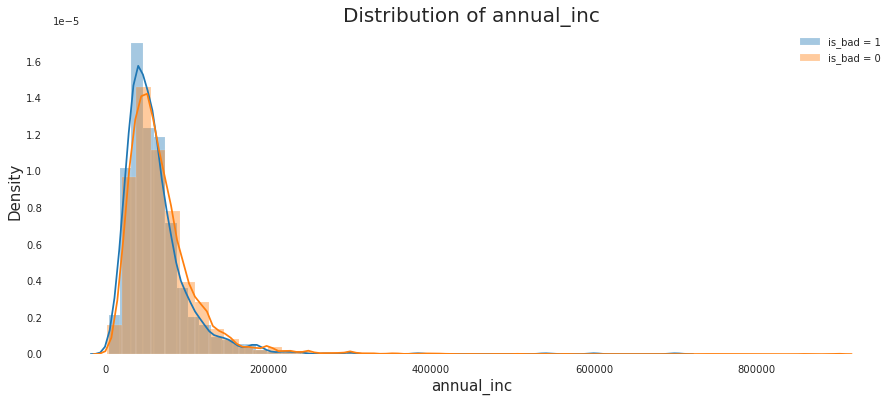

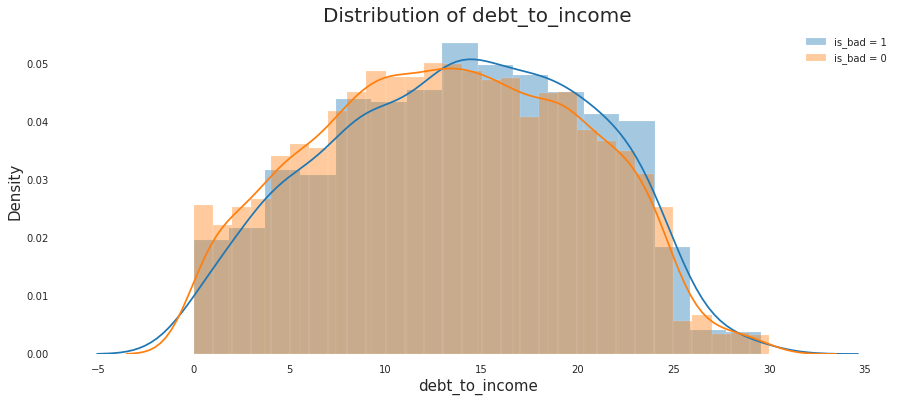

<Figure size 1080x432 with 0 Axes>

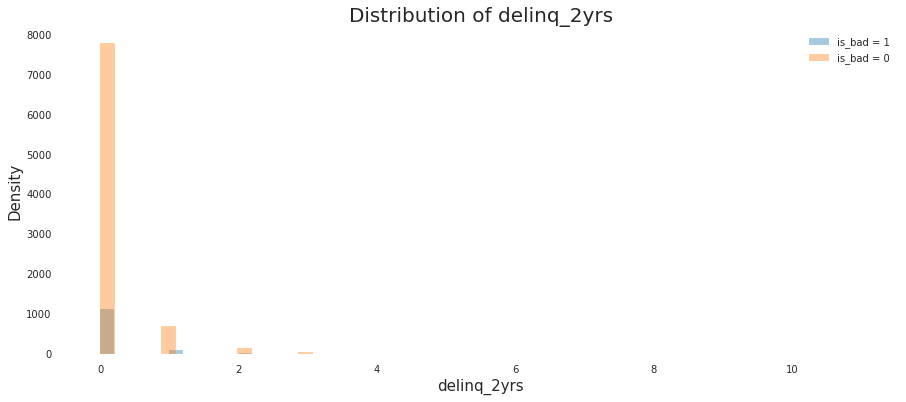

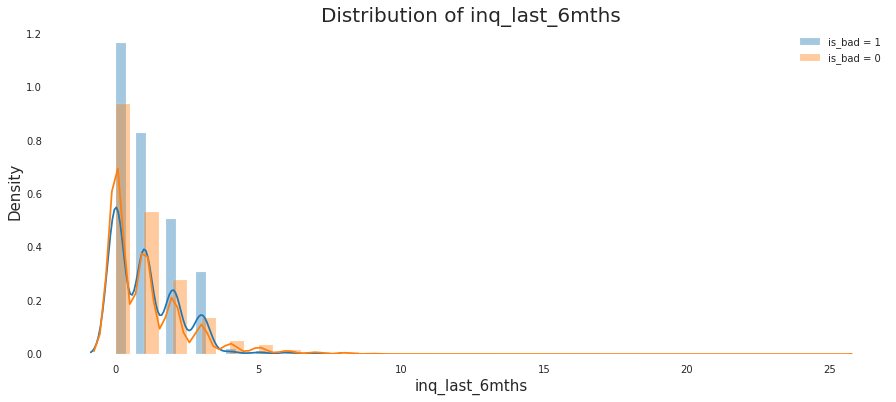

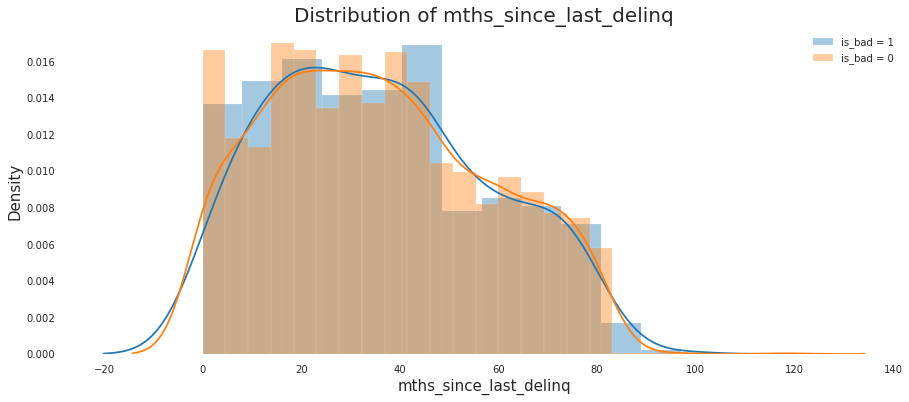

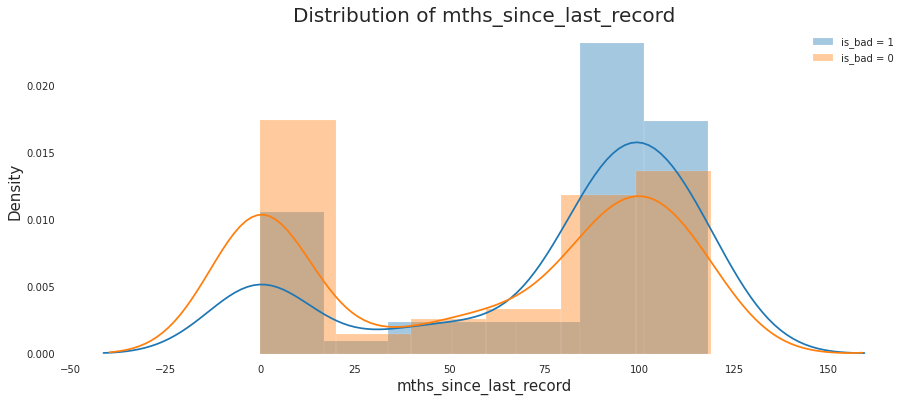

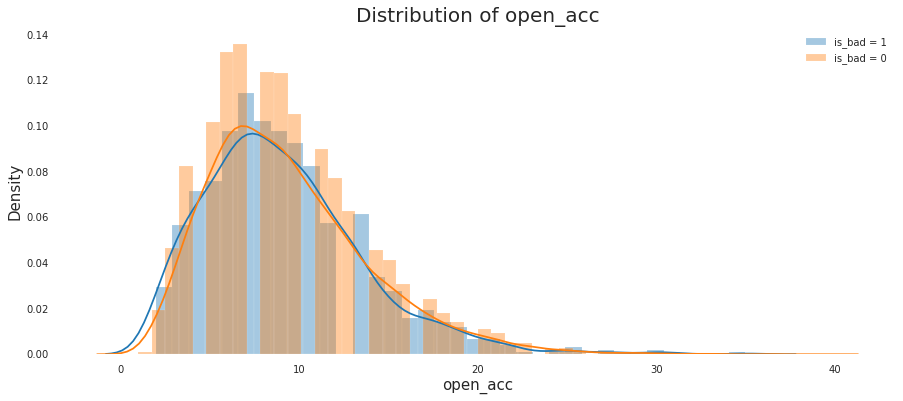

<Figure size 1080x432 with 0 Axes>

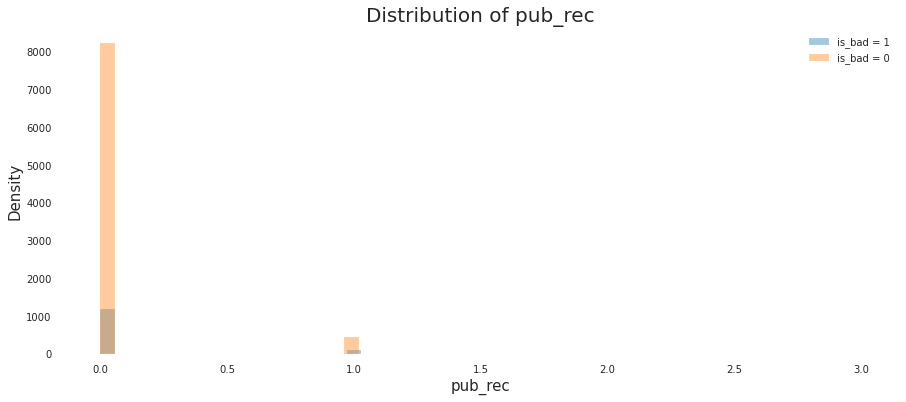

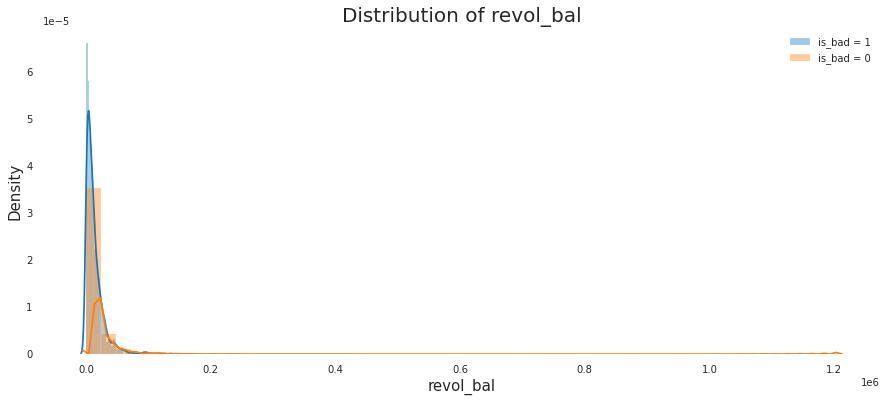

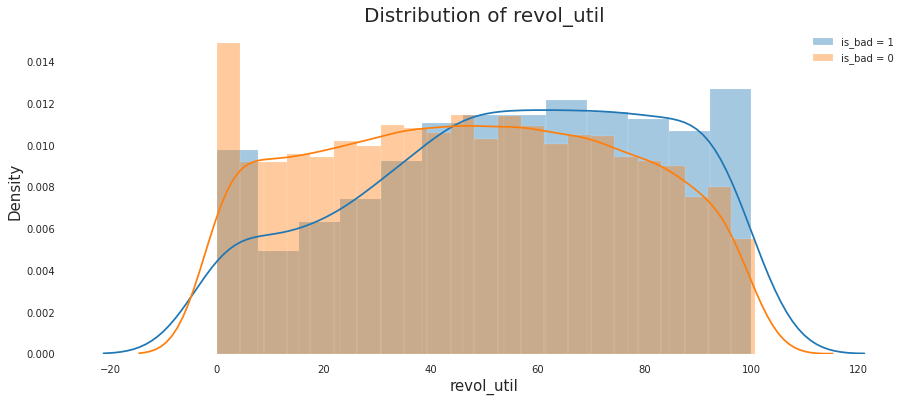

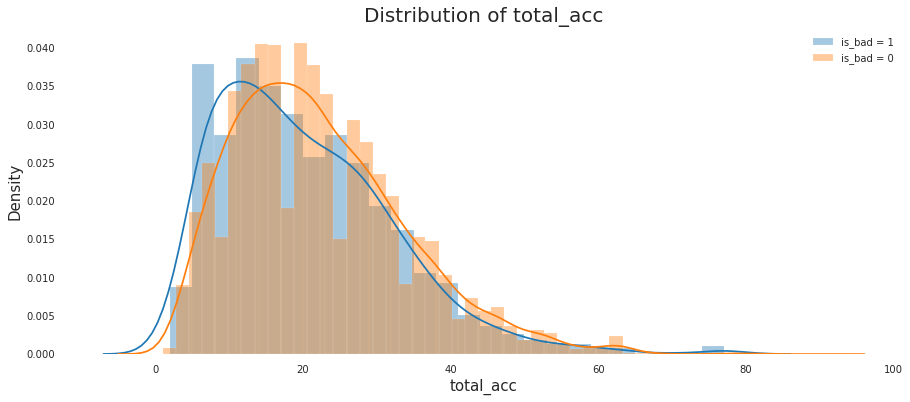

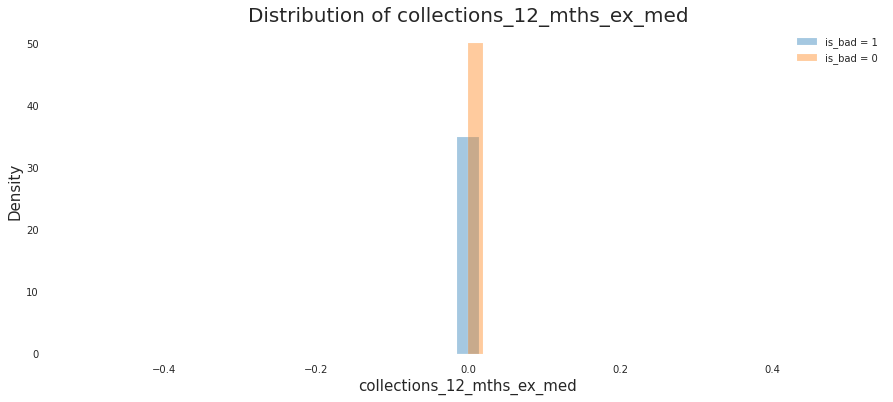

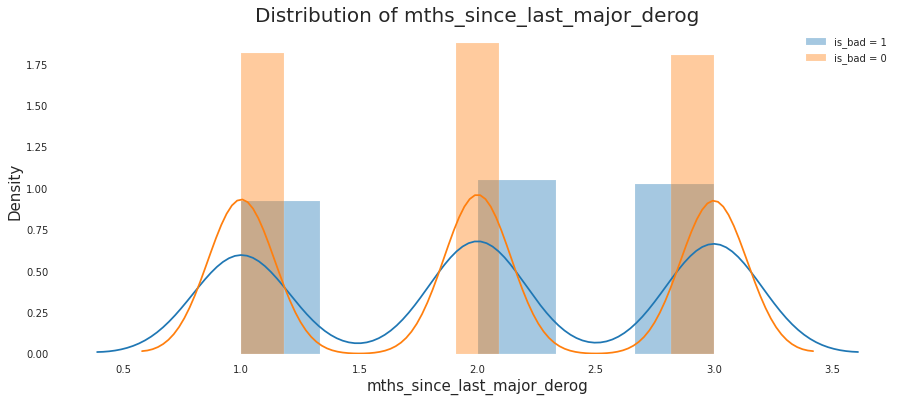

In [54]:
import seaborn as sns

# Plot out the dist plots + kde
def plot_dist(df, param):
    #param = 'debt_to_income'

    try:
        fig = plt.figure(figsize=(15,6))
        plt.xlabel(param ,fontsize=15)
        plt.ylabel('Density',fontsize=15)
        sns.distplot(df.loc[df['is_bad'] == 1, param], label = 'is_bad = 1')
        sns.distplot(df.loc[df['is_bad'] == 0, param], label = 'is_bad = 0')
        
    except:
        fig.clear()
        fig = plt.figure(figsize=(15,6))
        plt.xlabel(param ,fontsize=15)
        plt.ylabel('Density',fontsize=15)
        sns.distplot(df.loc[df['is_bad'] == 1, param], label = 'is_bad = 1', kde=False)
        sns.distplot(df.loc[df['is_bad'] == 0, param], label = 'is_bad = 0', kde=False)
    plt.legend()
    plt.title('Distribution of {}'.format(param), fontsize=20)


for param in df._get_numeric_data().columns:
    if param != 'is_bad':
        print(param)
        try:
            plot_dist(df, param)
        except Exception as e:
            print(e)

In [55]:
!pip list | grep seaborn

seaborn                            0.10.0


In [56]:
df.sample(5)

,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,debt_to_income,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
2909,0,5,RENT,63000.0,not verified,n,debt consolidation,787xx,TX,15.66,...,NaN,19.0,0.0,31097,38.1,45.0,f,0.0,1,PC3
351,0,4,MORTGAGE,60000.0,not verified,n,debt consolidation,837xx,ID,19.72,...,NaN,8.0,0.0,19500,30.9,14.0,f,0.0,3,PC3
9984,0,6,RENT,69790.0,not verified,n,major purchase,452xx,OH,1.74,...,NaN,4.0,0.0,3760,8.0,13.0,f,0.0,3,PC1
202,0,5,OWN,14400.0,VERIFIED - income source,n,other,330xx,FL,10.08,...,NaN,5.0,0.0,6940,31.7,7.0,f,0.0,2,PC1
2598,0,2,OWN,63000.0,not verified,n,other,700xx,LA,20.84,...,NaN,16.0,0.0,1187,8.7,22.0,f,0.0,1,PC3


In [57]:
# Split out the datetime columns into years, months, days
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)
df['cr_line_yrs'] = df.earliest_cr_line.dt.year
df['cr_line_mths'] = df.earliest_cr_line.dt.month
df['cr_line_days'] = df.earliest_cr_line.dt.day
df.drop('earliest_cr_line', axis=1, inplace=True)

In [58]:
# List all of the column data types as they stand
df.dtypes

is_bad                           int64
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
pymnt_plan                      object
purpose_cat                     object
zip_code                        object
addr_state                      object
debt_to_income                 float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                        int64
revol_util                     float64
total_acc                      float64
initial_list_status             object
collections_12_mths_ex_med     float64
mths_since_last_major_derog      int64
policy_code                     object
cr_line_yrs                    float64
cr_line_mths                   float64
cr_line_days             

Text(0, 0.5, 'data type')

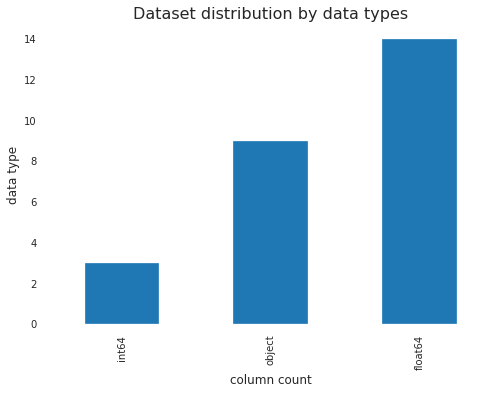

In [59]:
df.dtypes.value_counts().sort_values().plot(kind='bar')
plt.title('Dataset distribution by data types',fontsize=16)
plt.xlabel('column count',fontsize=12)
plt.ylabel('data type',fontsize=12)

In [60]:
# Need to convert 'emp_length' to a numerical column
# Any values missing or 'na' will be replaced by 0 since it makes sense that they may not have been employed a long time
def convert_num(x):
    try:
        x = int(x)
        if x > 10:
            x = 10
    except:
        x = 0  
    
    return x

df['emp_length'] = df.emp_length.apply(convert_num)

In [61]:
df.emp_length.unique()

array([10,  1,  4,  6,  2,  3,  5,  8,  7,  9,  0])

In [62]:
# Now list out the final numerical and categorical columns
num_cols = list(df._get_numeric_data().columns)
cat_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
num_cols.remove('is_bad')
target = ['is_bad']

In [63]:
# Make sure all categorical columns that contain text have the same case
for cat_col in cat_cols:
    df[cat_col] = df[cat_col].str.lower()

In [64]:
df[cat_col] = df[cat_col].astype(str)  # also just make sure they are in fact strings

In [65]:
df.dtypes

is_bad                           int64
emp_length                       int64
home_ownership                  object
annual_inc                     float64
verification_status             object
pymnt_plan                      object
purpose_cat                     object
zip_code                        object
addr_state                      object
debt_to_income                 float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                        int64
revol_util                     float64
total_acc                      float64
initial_list_status             object
collections_12_mths_ex_med     float64
mths_since_last_major_derog      int64
policy_code                     object
cr_line_yrs                    float64
cr_line_mths                   float64
cr_line_days             

In [66]:
df[cat_cols].dtypes

pymnt_plan             object
policy_code            object
zip_code               object
verification_status    object
addr_state             object
initial_list_status    object
home_ownership         object
purpose_cat            object
dtype: object

In [67]:
df[num_cols].dtypes

emp_length                       int64
annual_inc                     float64
debt_to_income                 float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                        int64
revol_util                     float64
total_acc                      float64
collections_12_mths_ex_med     float64
mths_since_last_major_derog      int64
cr_line_yrs                    float64
cr_line_mths                   float64
cr_line_days                   float64
dtype: object

In [68]:
df[target].dtypes

is_bad    int64
dtype: object

emp_length
annual_inc
debt_to_income
delinq_2yrs
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
collections_12_mths_ex_med
mths_since_last_major_derog
cr_line_yrs
cr_line_mths
cr_line_days


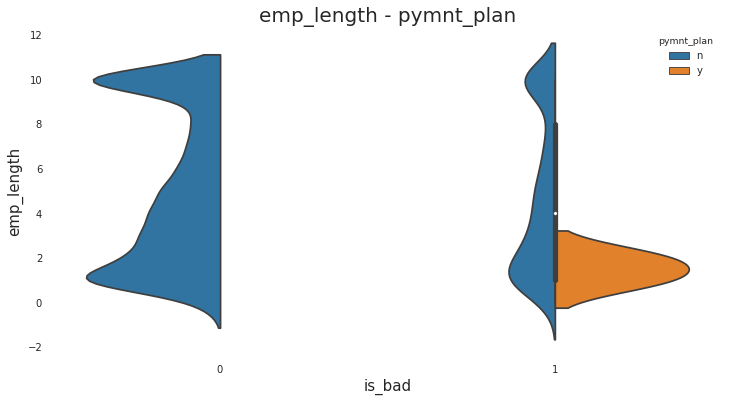

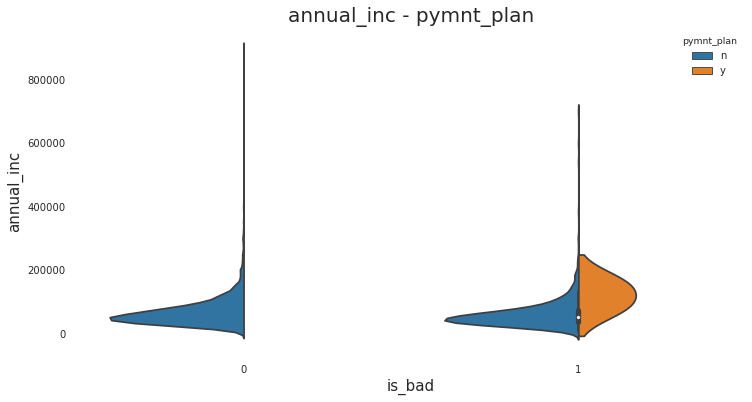

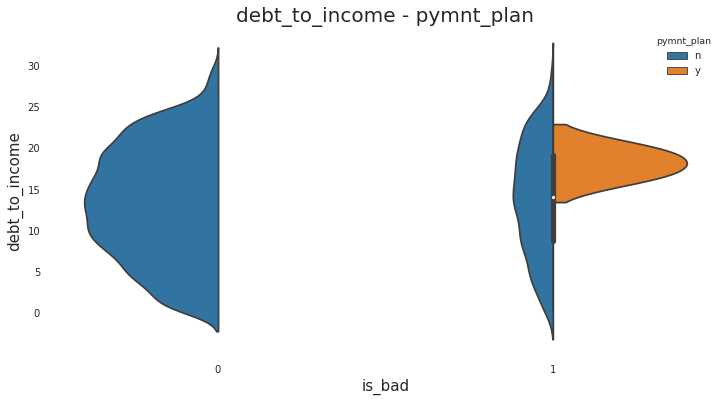

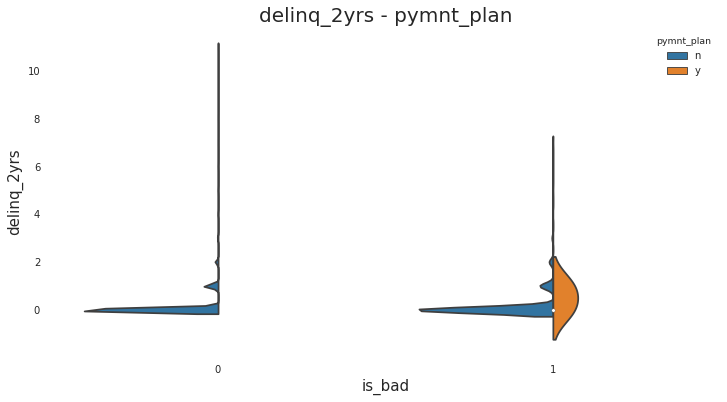

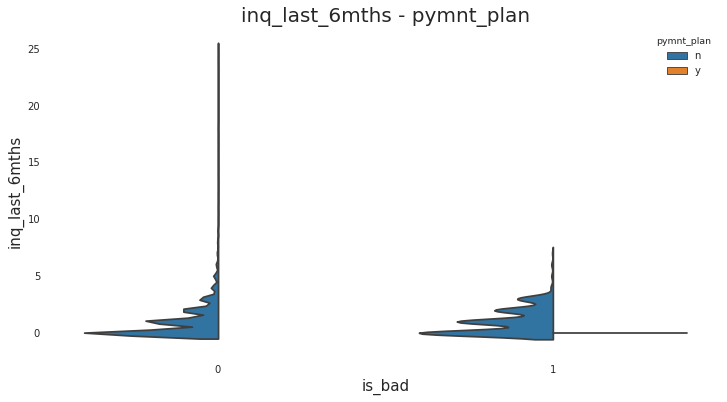

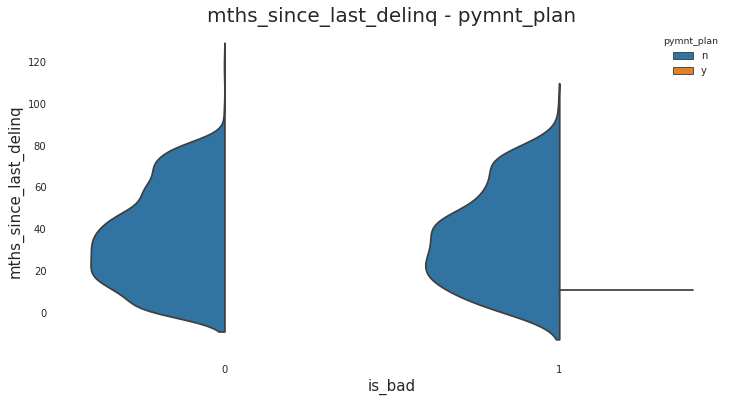

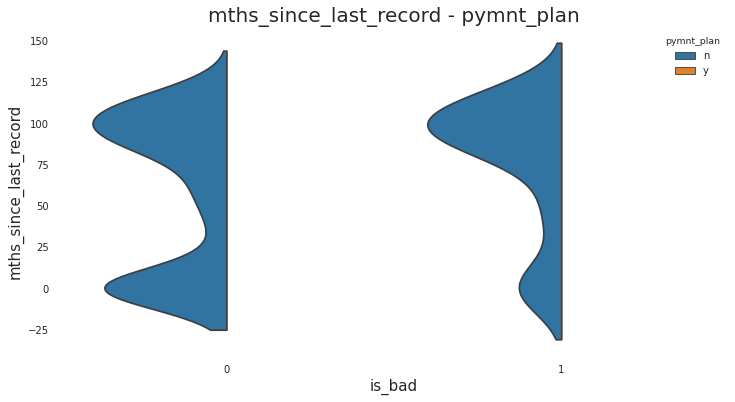

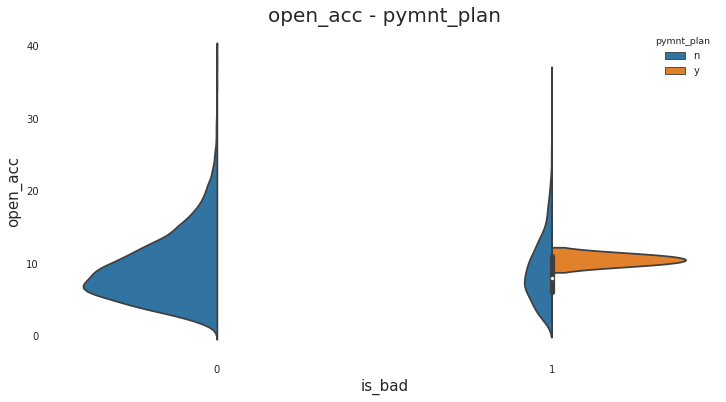

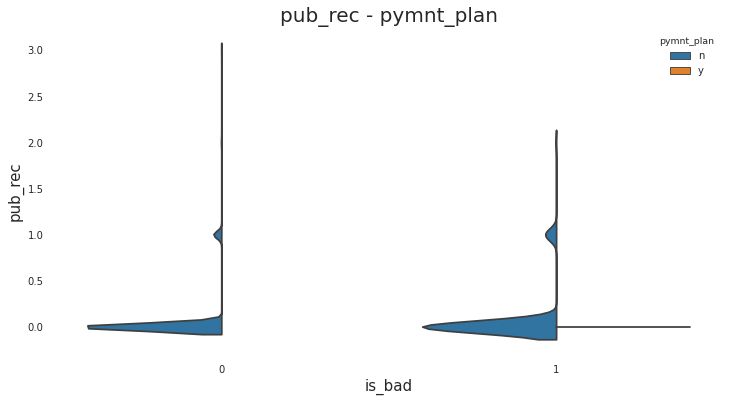

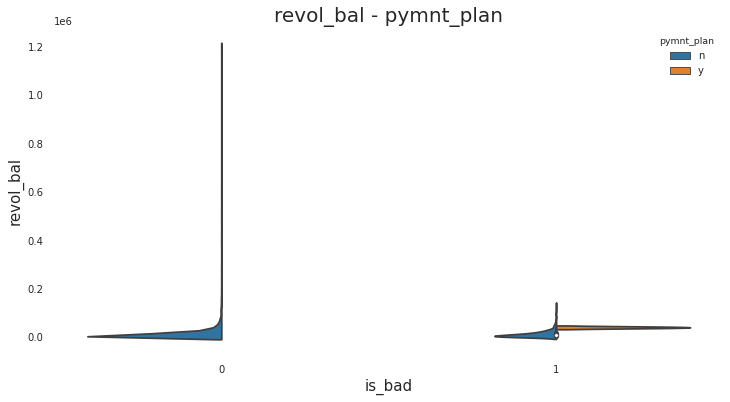

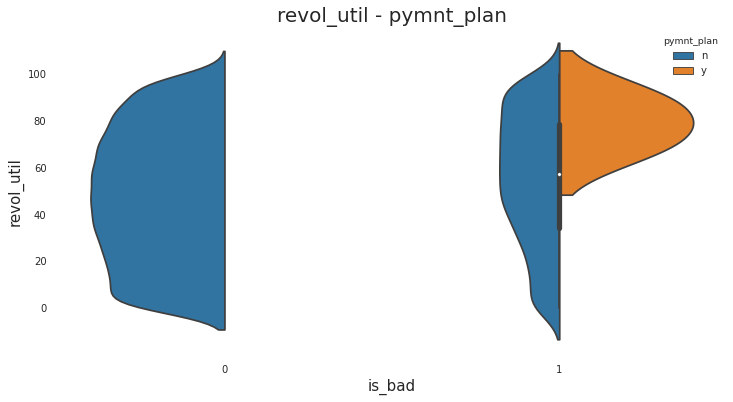

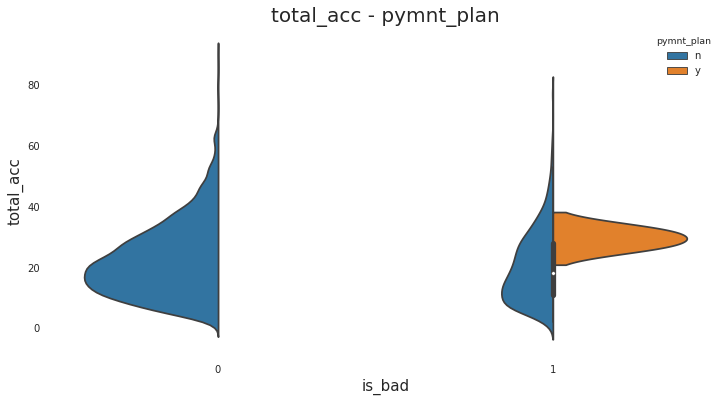

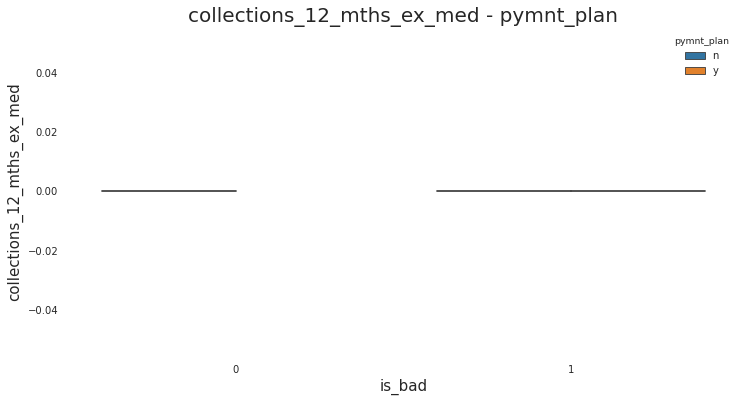

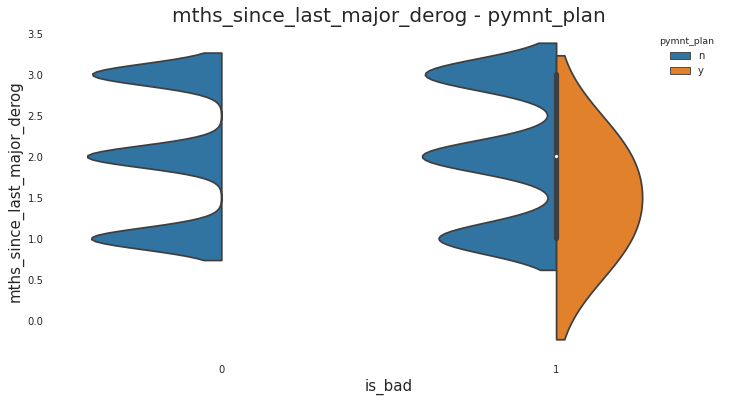

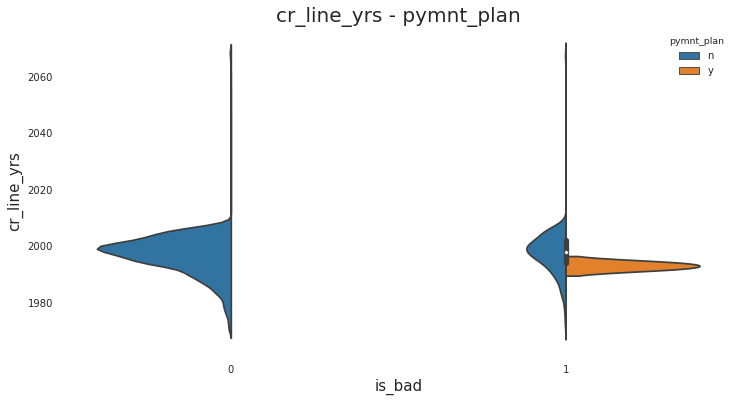

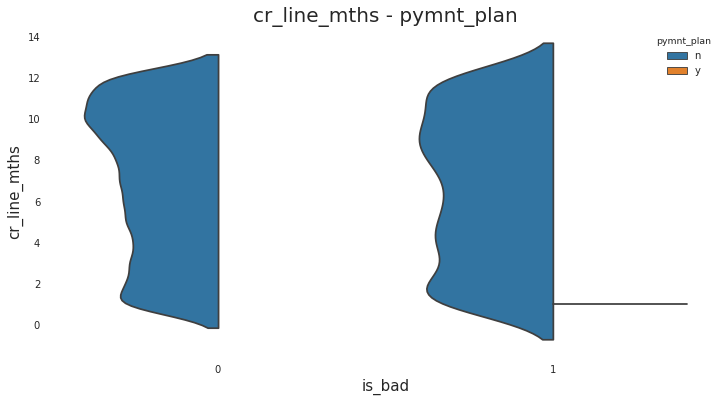

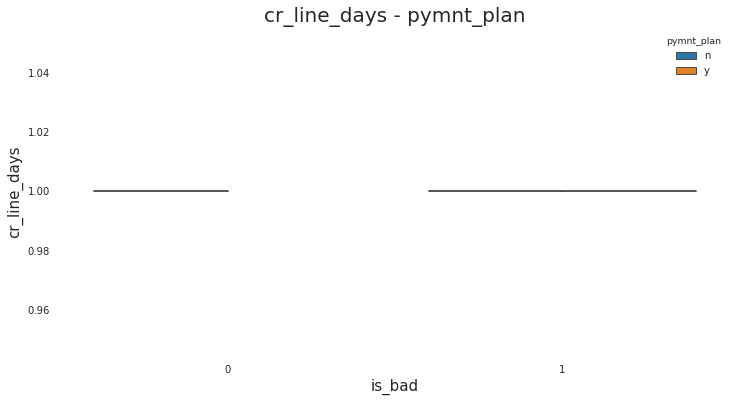

In [69]:
# Plot out some violin plots
def plot_violin(df, param1, param2):
    fig = plt.figure(figsize=(12,6))
    sns.violinplot(x="is_bad", y=param1, data=df, hue=param2, split=True)
    plt.title("{0} - {1}".format(param1, param2), fontsize=20)
    plt.xlabel("is_bad", fontsize=15)
    plt.ylabel(param1, fontsize=15)

bin_param = 'pymnt_plan'
for param in df._get_numeric_data().columns:
        if param != 'is_bad':
            print(param)
            try:
                plot_violin(df, param, bin_param)
            except Exception as e:
                print(e)

emp_length
annual_inc
debt_to_income
delinq_2yrs
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
collections_12_mths_ex_med
mths_since_last_major_derog
cr_line_yrs
cr_line_mths
cr_line_days


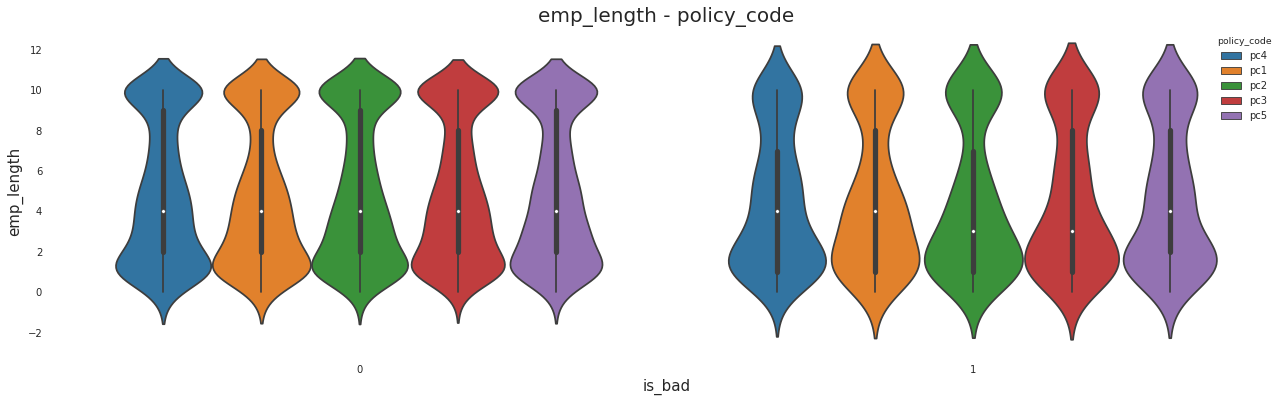

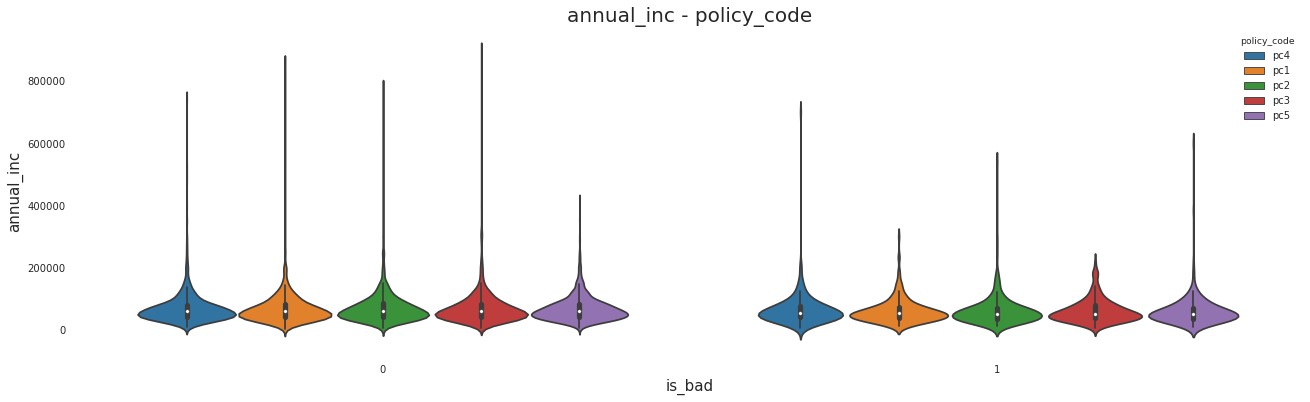

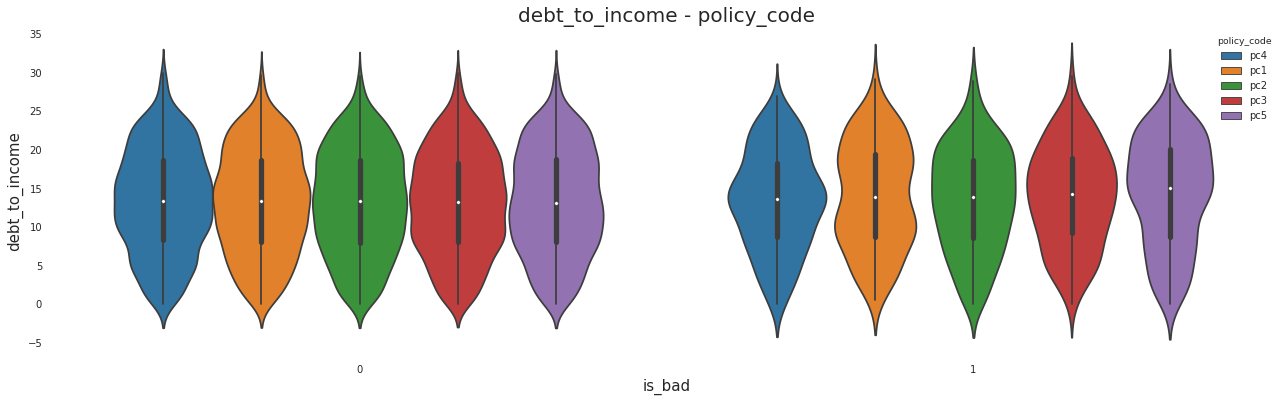

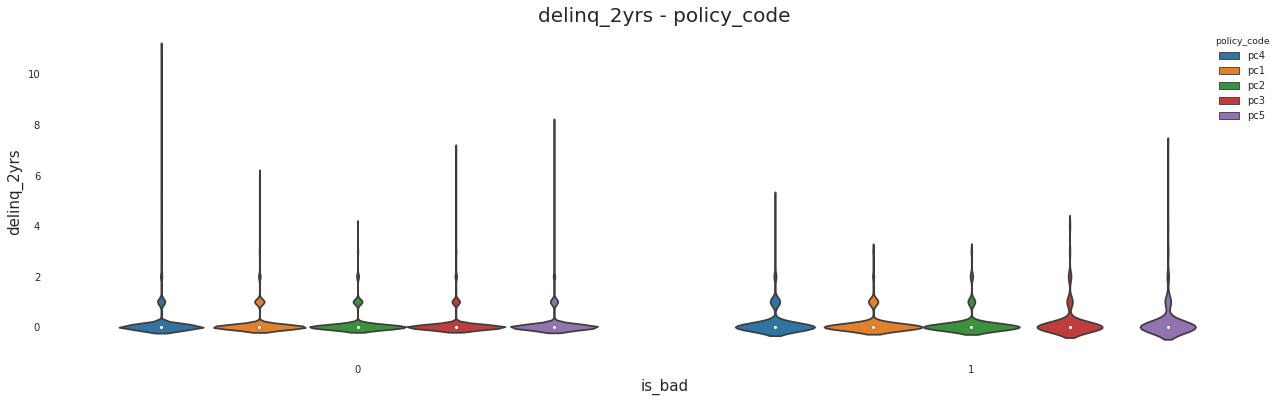

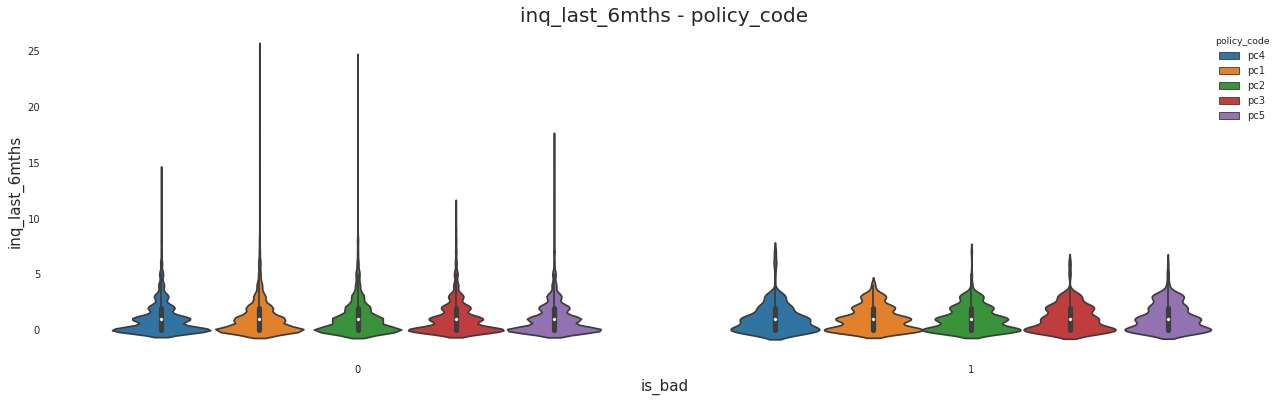

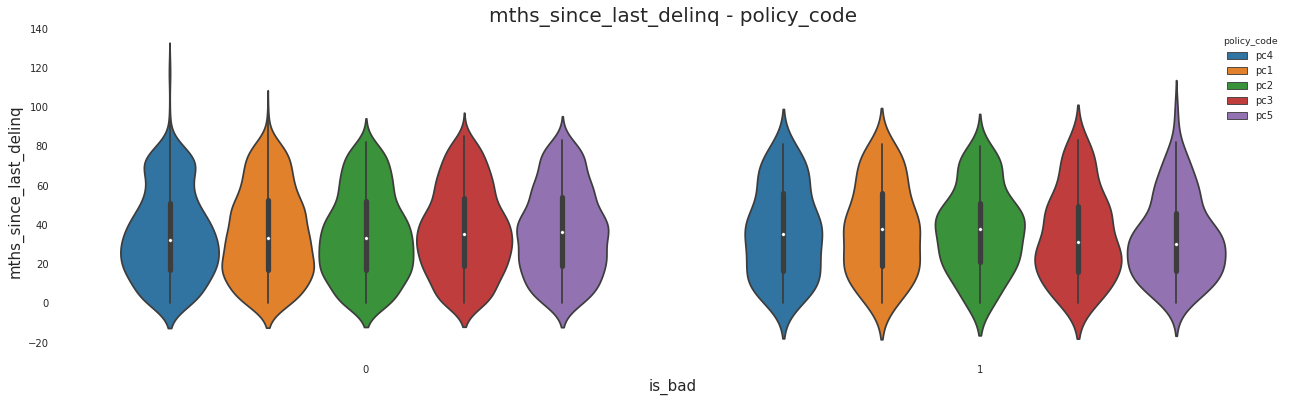

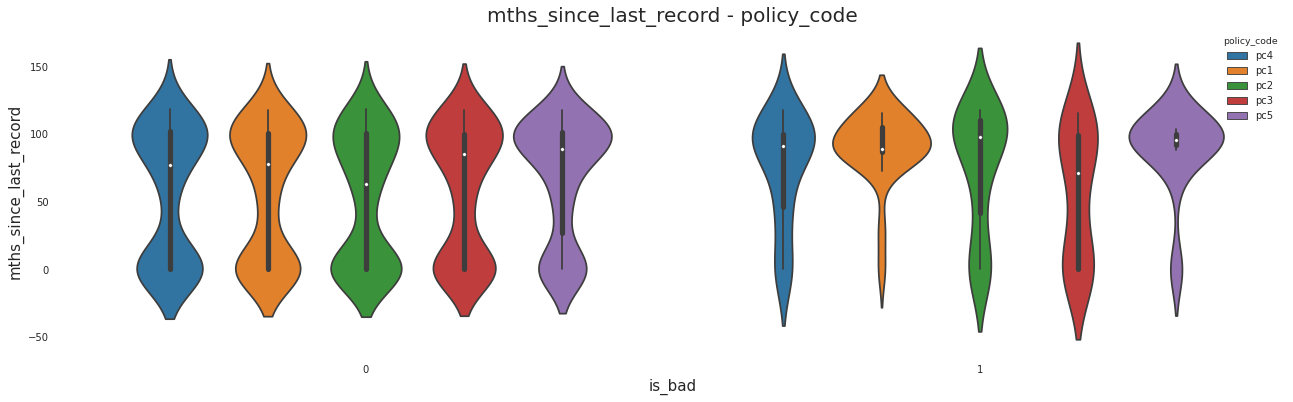

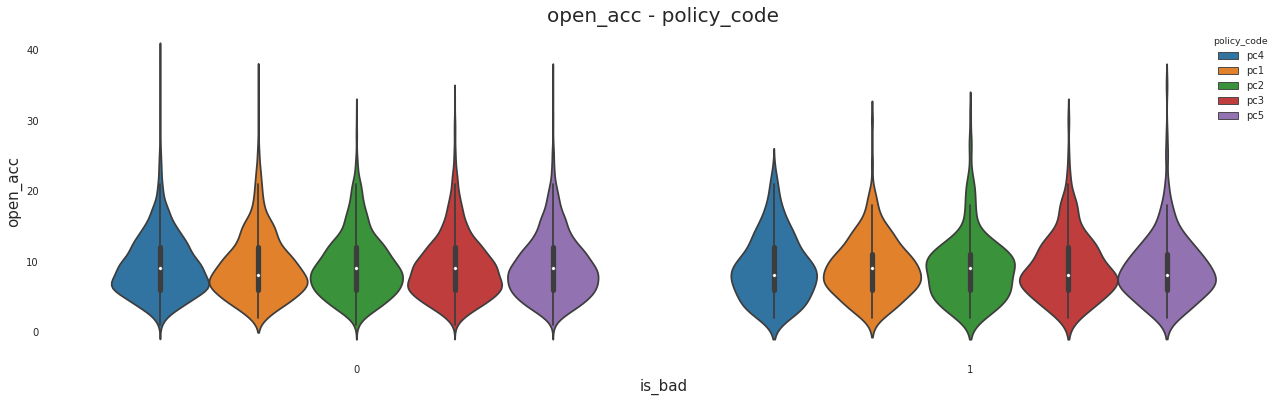

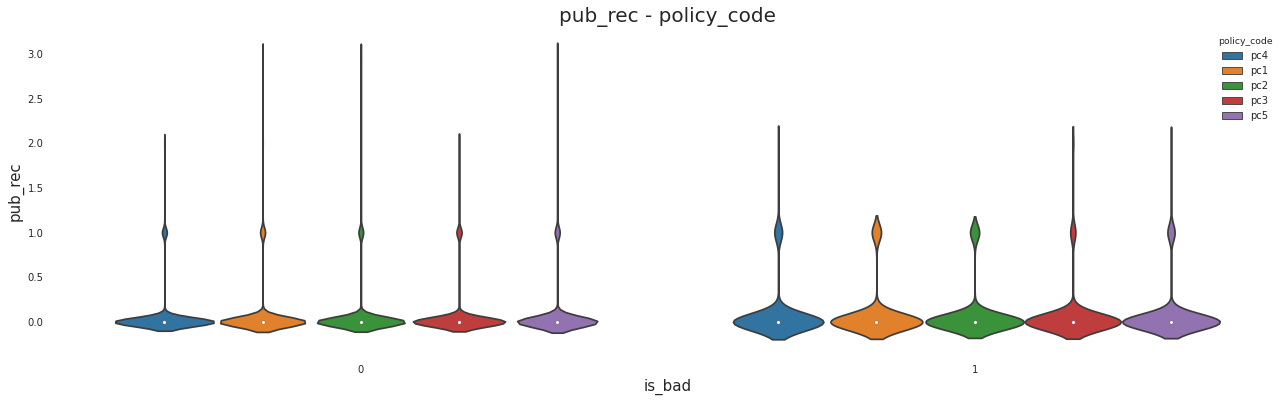

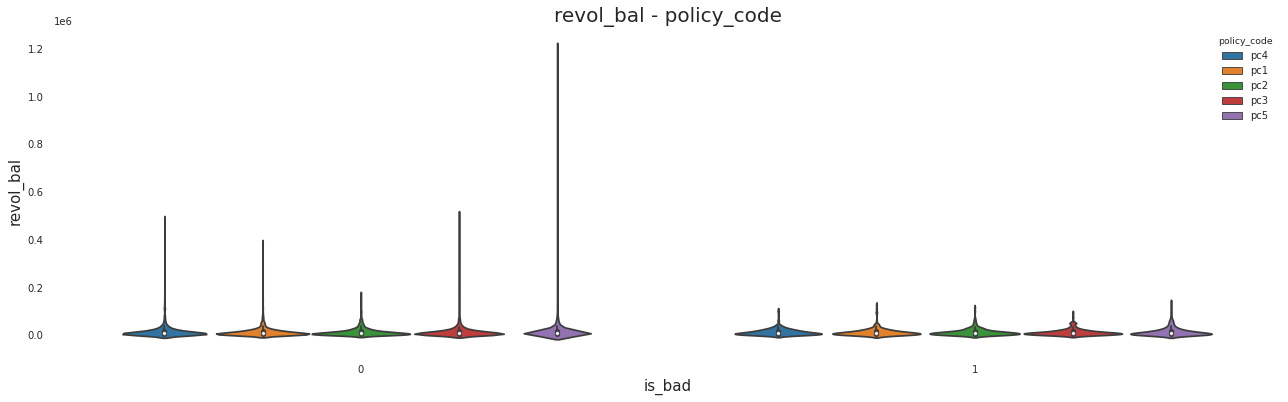

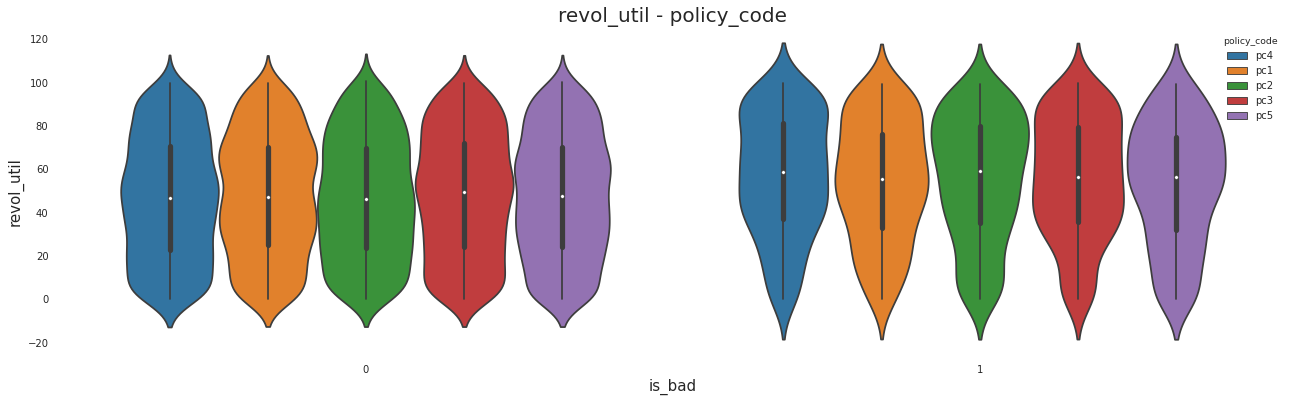

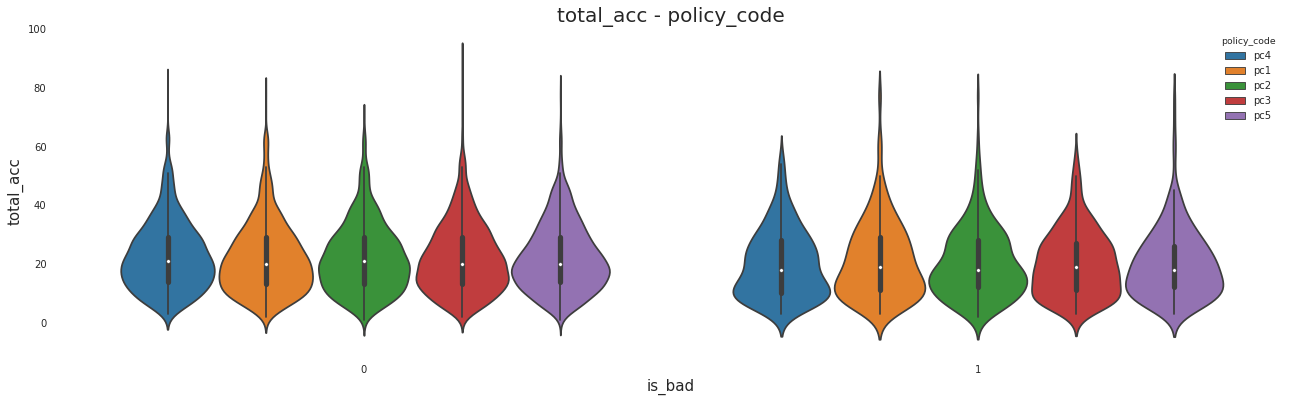

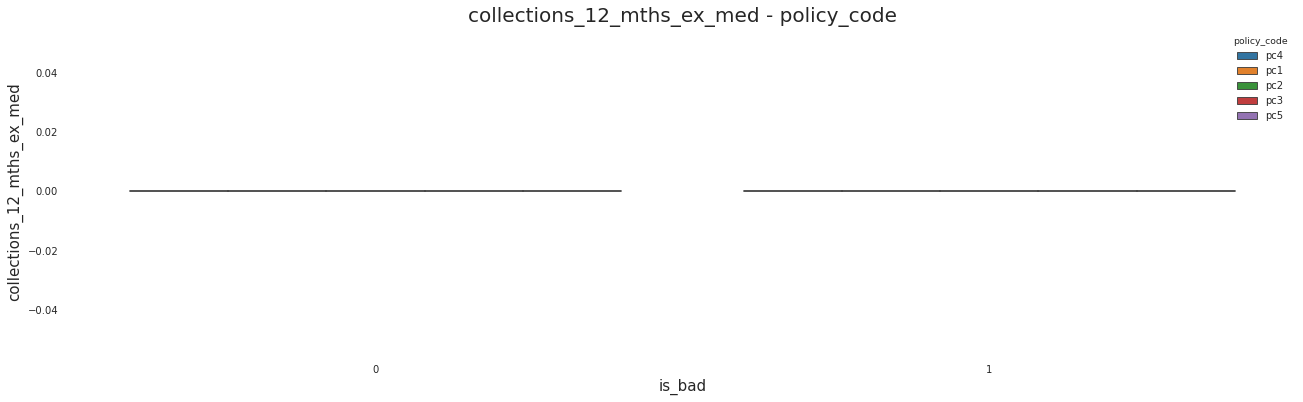

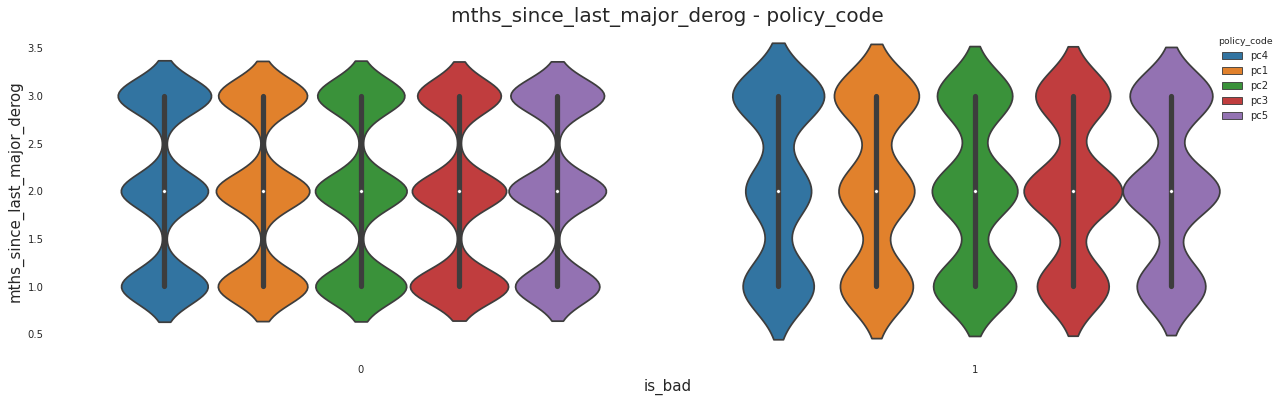

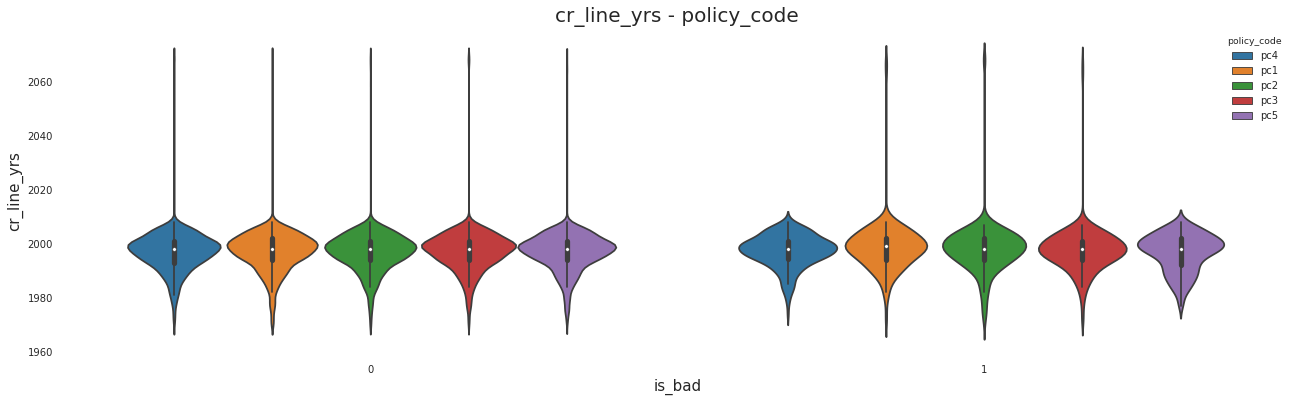

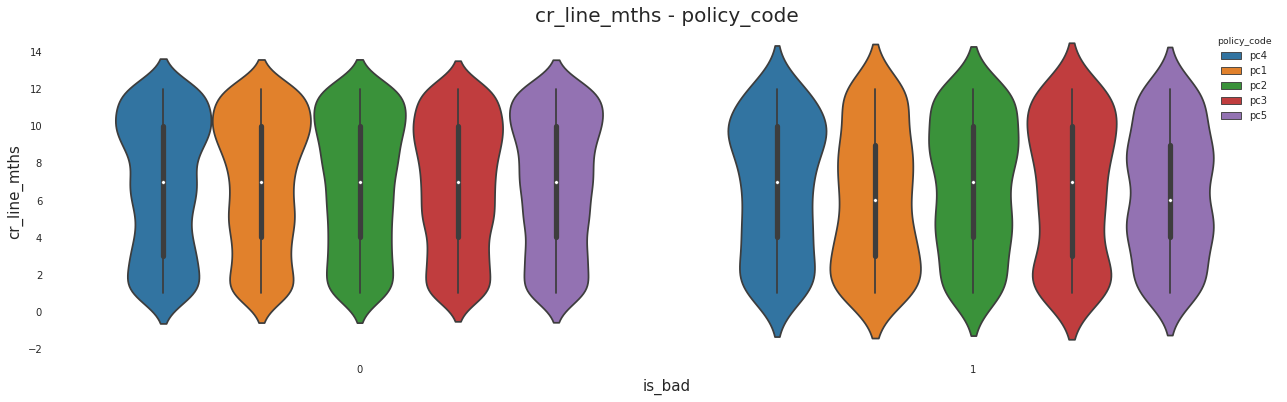

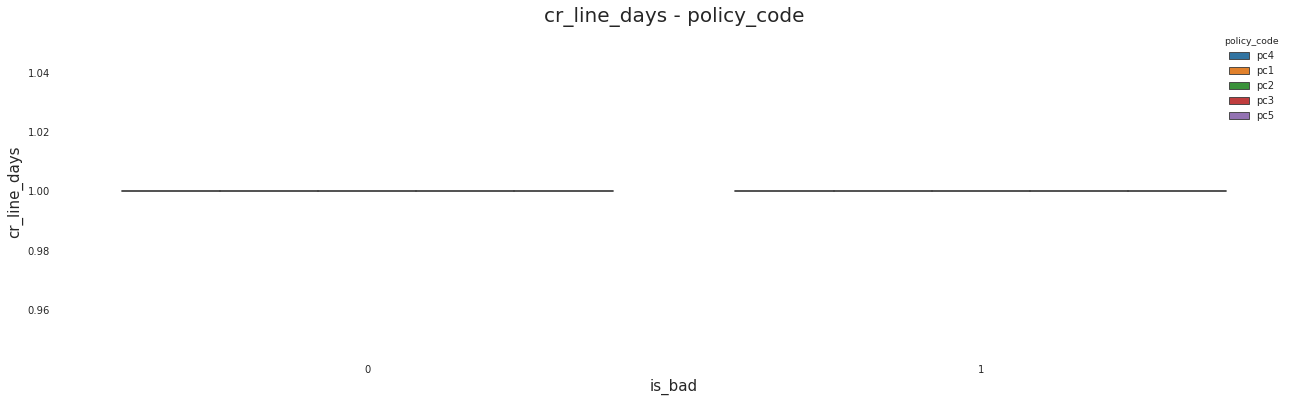

In [70]:
# Plot out some more violin plots
def plot_violin(df, param1, param2):
    fig = plt.figure(figsize=(22,6))
    sns.violinplot(x="is_bad", y=param1, data=df, hue=param2)
    plt.title("{0} - {1}".format(param1, param2), fontsize=20)
    plt.xlabel("is_bad", fontsize=15)
    plt.ylabel(param1, fontsize=15)

bin_param = 'policy_code'
for param in df._get_numeric_data().columns:
        if param != 'is_bad':
            print(param)
            try:
                plot_violin(df, param, bin_param)
            except Exception as e:
                print(e)

Text(0.5, 1.0, 'Number of defaulted loans per state')

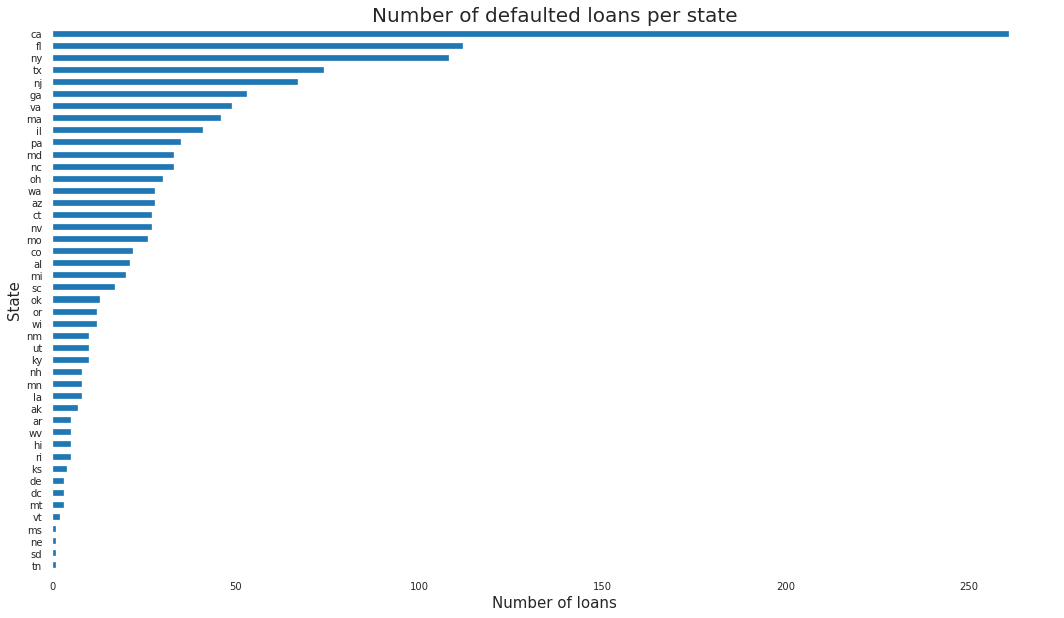

In [71]:
fig = plt.figure(figsize=(18,10))
df[df['is_bad']==1].groupby('addr_state')['is_bad'].count().sort_values().plot(kind='barh')
plt.ylabel('State',fontsize=15)
plt.xlabel('Number of loans', fontsize=15)
plt.title('Number of defaulted loans per state', fontsize=20)

Text(0.5, 1.0, 'Number of good loans per state')

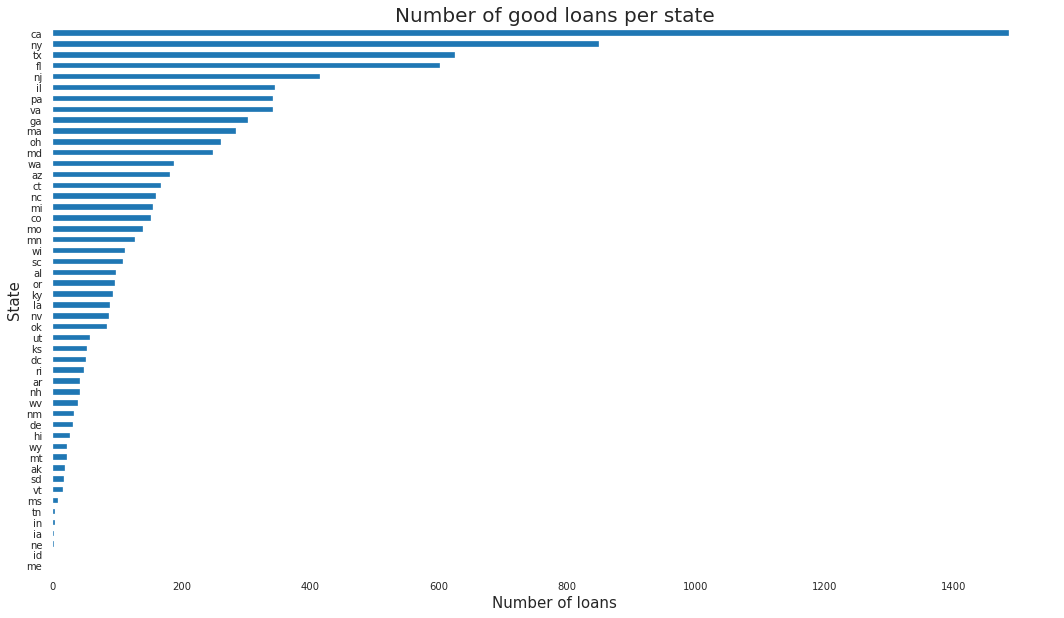

In [72]:
fig = plt.figure(figsize=(18,10))
df[df['is_bad']==0].groupby('addr_state')['is_bad'].count().sort_values().plot(kind='barh')
plt.ylabel('State',fontsize=15)
plt.xlabel('Number of loans', fontsize=15)
plt.title('Number of good loans per state', fontsize=20)

In [73]:
df.query('mths_since_last_record >= 0 and is_bad == 1')

,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,debt_to_income,...,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,cr_line_yrs,cr_line_mths,cr_line_days
106,1,1,rent,36000.0,not verified,n,debt consolidation,013xx,ma,17.27,...,7976,47.2,15.0,f,0.0,1,pc3,1998.0,12.0,1.0
151,1,10,mortgage,39168.0,not verified,n,debt consolidation,945xx,ca,24.85,...,6347,81.6,30.0,f,0.0,1,pc2,1997.0,3.0,1.0
225,1,8,rent,82000.0,verified - income,n,house,930xx,ca,10.38,...,5045,71.1,16.0,f,0.0,1,pc1,2001.0,2.0,1.0
333,1,2,own,20000.0,verified - income,n,debt consolidation,616xx,il,14.34,...,2398,74.9,6.0,f,0.0,3,pc2,2004.0,8.0,1.0
375,1,2,rent,63000.0,verified - income source,n,debt consolidation,906xx,ca,11.90,...,2014,83.9,11.0,f,0.0,1,pc4,2000.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9550,1,3,rent,108901.0,verified - income,n,debt consolidation,335xx,fl,13.43,...,30497,93.8,14.0,f,0.0,3,pc4,1991.0,12.0,1.0
9589,1,1,mortgage,65964.0,verified - income source,n,car,228xx,va,20.59,...,12445,58.2,7.0,f,0.0,3,pc2,1999.0,5.0,1.0
9628,1,3,own,62910.0,verified - income,n,debt consolidation,206xx,md,15.60,...,6582,96.8,21.0,f,0.0,1,pc4,2002.0,4.0,1.0
9825,1,3,rent,54000.0,not verified,n,debt consolidation,940xx,ca,17.42,...,8593,96.6,14.0,f,0.0,3,pc1,2001.0,12.0,1.0


## Fill in missing values

In [74]:
df['delinq_2yrs'] = df.delinq_2yrs.fillna(0)

def make_bin(x):
    if int(x) > 0:
        return '1'
    else:
        return '0'

In [75]:
df['inq_last_6mths'].fillna(0, inplace=True)

In [76]:
df['mths_since_last_delinq'].fillna(0, inplace=True)

In [77]:
df['mths_since_last_record'].max()
df['mths_since_last_record'].fillna(df.mths_since_last_record.max(), inplace=True)
df['mths_since_last_record'] = df['mths_since_last_record'].astype(int)

In [78]:
df['pub_rec'].fillna(0, inplace=True)
df['pub_rec'] = df['pub_rec'].astype(int)

In [79]:
df.drop('cr_line_days', axis=1, inplace=True)

In [80]:
pd.options.mode.use_inf_as_na = True
df['cr_line_mths'].fillna(df.cr_line_mths.mode()[0], inplace=True)  # 10.0 is the mode of the data
df['cr_line_mths'] = df['cr_line_mths'].astype(int)

In [81]:
df.drop('collections_12_mths_ex_med', axis=1, inplace=True)

In [83]:
df['annual_inc'].fillna(df.annual_inc.median(), inplace=True)

In [84]:
df['open_acc'].fillna(df.open_acc.median(), inplace=True)

In [87]:
df['revol_util'].fillna(df.revol_util.median(), inplace=True)

In [88]:
df['total_acc'].fillna(df.total_acc.median(), inplace=True)

In [89]:
df['cr_line_yrs'].fillna(df.cr_line_yrs.median(), inplace=True)

In [92]:
corr = df.corr()['is_bad'].sort_values()

# Display correlations
print('Most Positive Correlations with "is_bad"')
print(20*"-")
print(corr.tail(10))
print()
print('Most Negative Correlations with "is_bad"')
print(20*"-")
print(corr.head(10))

Most Positive Correlations with "is_bad"
--------------------
inq_last_6mths                -0.001007
mths_since_last_delinq         0.014576
mths_since_last_record         0.014978
mths_since_last_major_derog    0.015481
delinq_2yrs                    0.021897
cr_line_yrs                    0.029565
debt_to_income                 0.029873
pub_rec                        0.032218
revol_util                     0.087797
is_bad                         1.000000
Name: is_bad, dtype: float64

Most Negative Correlations with "is_bad"
--------------------
total_acc                     -0.055271
annual_inc                    -0.050966
cr_line_mths                  -0.035356
emp_length                    -0.033449
open_acc                      -0.020341
revol_bal                     -0.016202
inq_last_6mths                -0.001007
mths_since_last_delinq         0.014576
mths_since_last_record         0.014978
mths_since_last_major_derog    0.015481
Name: is_bad, dtype: float64


In [93]:
corr = df.corr()['debt_to_income'].sort_values()

# Display correlations
print('Most Positive Correlations with "dti"')
print(20*"-")
print(corr.tail(10))
print()
print('Most Negative Correlations with "dti"')
print(20*"-")
print(corr.head(10))

Most Positive Correlations with "dti"
--------------------
cr_line_mths             -0.002689
inq_last_6mths            0.013220
is_bad                    0.029873
mths_since_last_record    0.043172
emp_length                0.061746
revol_bal                 0.163794
total_acc                 0.233594
revol_util                0.270993
open_acc                  0.300922
debt_to_income            1.000000
Name: debt_to_income, dtype: float64

Most Negative Correlations with "dti"
--------------------
annual_inc                    -0.130124
cr_line_yrs                   -0.054571
delinq_2yrs                   -0.034213
mths_since_last_delinq        -0.017424
mths_since_last_major_derog   -0.007031
pub_rec                       -0.005214
cr_line_mths                  -0.002689
inq_last_6mths                 0.013220
is_bad                         0.029873
mths_since_last_record         0.043172
Name: debt_to_income, dtype: float64


In [91]:
# Save off the data as a checkpoint
df.to_pickle("./data/baseline_fe_data.pkl")
df.to_csv("./data/baseline_fe_data.csv")